In [125]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES
from pyts.classification import TimeSeriesForest

In [126]:
dataset = pd.read_csv('../../datasets/sp_500_stocks/sp500_stocks.csv')

In [127]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
22524,2010-01-04,AMD,9.700000,9.700000,9.900000,9.680000,9.790000,18748700.0
37540,2010-01-04,APD,53.128727,76.928772,77.021278,75.587418,75.957443,1131483.0
1152478,2010-01-04,MKC,13.617592,18.150000,18.205000,18.030001,18.205000,980000.0
255272,2010-01-04,BKNG,222.359650,223.960007,225.300003,221.580002,222.320007,863200.0
469250,2010-01-04,CPRT,2.275625,2.275625,2.308750,2.271875,2.295625,4688000.0
...,...,...,...,...,...,...,...,...
874681,2024-12-02,HLT,250.470001,250.470001,254.335007,249.606293,253.440002,805471.0
889697,2024-12-02,HRL,32.139999,32.139999,32.480000,31.850000,32.480000,3019392.0
893451,2024-12-02,HST,18.389999,18.389999,18.590000,18.270000,18.490000,4656098.0
814617,2024-12-02,GM,55.040001,55.040001,55.619999,54.689999,55.500000,9200689.0


In [128]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
dataset = dataset.drop(columns=['Adj Close', "Volume", "Close", "Open", "Low", "High"])
dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
dataset['quarter'] = dataset['Date'].dt.quarter
def get_season(month):
    if month in [12, 1, 2]:
        return 0#'winter'
    elif month in [3, 4, 5]:
        return 1#'spring'
    elif month in [6, 7, 8]:
        return 2#'summer'
    else:
        return 3#'autumn'
dataset['season'] = dataset['Month'].apply(get_season)
dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


days_ago = 30

dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
dataset["price_365_days_ago"] = dataset["average_price"].shift(365)

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"]
fieldsPrice = ["average_price"]


dataset = dataset.dropna().reset_index(drop=True)

dataset

,Date,Symbol,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,price_30_days_ago,price_180_days_ago,price_365_days_ago
0,2010-01-06,EQT,733778,24.610778,2,1,2010,6,1,0,0,1,0,3,17.880000,26.055607,9.790000
1,2010-01-06,STLD,733778,18.910000,2,1,2010,6,1,0,0,1,0,3,10.295000,5.485000,76.304348
2,2010-01-06,IFF,733778,41.740000,2,1,2010,6,1,0,0,1,0,3,109.395000,15.954999,18.117500
3,2010-01-06,LLY,733778,35.385000,2,1,2010,6,1,0,0,1,0,3,6.659500,29.880000,223.440002
4,2010-01-06,EFX,733778,31.620000,2,1,2010,6,1,0,0,1,0,3,22.180000,24.600000,2.290312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581218,2024-12-02,HLT,739222,251.970650,0,12,2024,337,49,0,0,4,0,5447,271.625000,166.625000,34.469999
581219,2024-12-02,HRL,739222,32.165000,0,12,2024,337,49,0,0,4,0,5447,81.692497,63.709999,72.077499
581220,2024-12-02,HST,739222,18.430000,0,12,2024,337,49,0,0,4,0,5447,287.290009,230.209999,137.385002
581221,2024-12-02,GM,739222,55.154999,0,12,2024,337,49,0,0,4,0,5447,596.087494,145.105003,160.824997


In [129]:
dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]

In [130]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [131]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [132]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(blockDf['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = blockDf[blockDf['Date'] < train_max_day].shape[0]
    testSamples = len(blockDf.index) - trainSamples

    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test, blockDf

In [133]:
def getTestSet(dataset0, blockDf0, daysRange):
    min_date = pd.to_datetime(blockDf0['Date'].max())
    max_date = min_date + pd.DateOffset(days=daysRange)
    filtered_df = dataset0[(dataset0['Date'] >= min_date) & (dataset0['Date'] <= max_date)]
    aux = filtered_df.copy()
    aux = aux.drop("Date", axis=1)
    X_test = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test = aux.copy()

    return X_test, Y_test

In [152]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

testRanges = [30, 90, 180, 365, 730, 1825]

def getRmse(dataset01, blockDf01, rfModel, testRangesIdx):
    X_test0, Y_test0 = getTestSet(dataset01, blockDf01, testRanges[testRangesIdx])
    y_pred = rfModel.predict(X_test0)
    rmse01 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse01

def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=10, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
    return rmse0

def testTfAndGetRmse(dataset0, daysOfBlocks0, daysOfTraining0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=10, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    return rmse0

def testTfAndGetRmse2(dataset0, daysOfBlocks0, daysOfTraining0, block_size0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=10, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    rmseList0 = [rmse0]
    for i in [0, 1, 2]:
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=10, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[i])
        rfts.fit(X_train0, Y_train0)
        rmse1 = dict()
        rmse1[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
        rmse1[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
        rmse1[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
        rmse1[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
        rmse1[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
        rmse1[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
        rmseList0.append(rmse1)
    return rmseList0

def getGraphData(presitionDataArray, bRfp, bs):
    all_arr = [bRfp]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in bs:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(presitionDataArray[blockSize][r])

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

def convertListOfDictToDictOfList(dictList0):
    newDict = dict()
    for dict0 in dictList0:
        for key in dict0:
            if key not in newDict:
                newDict[key] = []
            newDict[key].append(dict0[key])
    return newDict

def runTestsAndGetResults(DaysRange, DaysTrainRange, blockSizes):

    daysOfBlocks = DaysRange
    daysOfTraining = DaysTrainRange
    for i in range(len(blockSizes)):
        blockSizes[i] = int(blockSizes[i])

    basicRFPrecision = []
    for i in range(50):
        rmse = testTfAndGetRmse(dataset, DaysRange, DaysTrainRange)
        basicRFPrecision.append(rmse)
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)

    precisionNonOverlapping = dict()
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
            precisionNonOverlapping[block_size].append(rmse0)
    
    precisionMovingBlock = dict()
    for block_size in blockSizes:
        precisionMovingBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
            precisionMovingBlock[block_size].append(rmse0)
    
    precisionCircularBlock = dict()
    for block_size in blockSizes:
        precisionCircularBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
            precisionCircularBlock[block_size].append(rmse0)
    
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size])
        precisionMovingBlock[block_size] = convertListOfDictToDictOfList(precisionMovingBlock[block_size])
        precisionCircularBlock[block_size] = convertListOfDictToDictOfList(precisionCircularBlock[block_size])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

def showGraph(basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock, blockSizes):
    all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping, basicRFPrecision, blockSizes)
    all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock, basicRFPrecision, blockSizes)
    all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock, basicRFPrecision, blockSizes)

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    plt.figure()

    bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
    bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
    bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
    set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bp1, '#2C7BB6')
    set_box_color(bp2, '#fdc086')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Non Overlapping')
    plt.plot([], c='#2C7BB6', label='Moving Block')
    plt.plot([], c='#fdc086', label='Circular Block')
    plt.legend()

    plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
    plt.tight_layout()
    plt.title(f"Comparación entre alternativas de bootstraps (Train: {DaysTrainRange} días | Test: {DaysRange - DaysTrainRange} días)")
    plt.xlabel("Tamaño de bloque")
    plt.ylabel("RMSE")

In [173]:
def runTestsAndGetResults2(DaysRange, DaysTrainRange, blockSizes):

    basicRFPrecision = []
    precisionNonOverlapping = dict()
    precisionMovingBlock = dict()
    precisionCircularBlock = dict()
    block_size = blockSizes[0]
    precisionNonOverlapping[block_size] = []
    precisionMovingBlock[block_size] = []
    precisionCircularBlock[block_size] = []
    for i in range(50):
        rmseList = testTfAndGetRmse2(dataset, DaysRange, DaysTrainRange, block_size)
        basicRFPrecision.append(rmseList[0])
        precisionNonOverlapping[block_size].append(rmseList[1])
        precisionMovingBlock[block_size].append(rmseList[2])
        precisionCircularBlock[block_size].append(rmseList[3])
    
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)
        
    for block_size0 in blockSizes:
        precisionNonOverlapping[block_size0] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size0])
        precisionMovingBlock[block_size0] = convertListOfDictToDictOfList(precisionMovingBlock[block_size0])
        precisionCircularBlock[block_size0] = convertListOfDictToDictOfList(precisionCircularBlock[block_size0])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

In [136]:
def runTestAndCompareOneSigleBlockSize(TrainDays, bSize):
    bs = [bSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults(TrainDays + max(testRanges), TrainDays, bs)
    showGraph(FrRMSE, NoRMSE[bSize], BmRMSE[bSize], CbRMSE[bSize], bs)
    

In [137]:
bs = [1415]
FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults(365 + max(testRanges), 365, bs)
#runTestAndCompareOneSigleBlockSize(365, 1415)

KeyboardInterrupt: 

In [ ]:
BmRMSE[1415].keys()

dict_keys([30, 90, 180, 365, 730, 1825])

In [ ]:
#showGraph(FrRMSE, NoRMSE, BmRMSE, CbRMSE, bs)

In [112]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def getLinesGraphData(rfReference):
    ticks0 = []
    rfReferenceMeans = []
    for key in rfReference:
        ticks0.append(str(key))
        rfReferenceMeans.append(sum(rfReference[key]) / len(rfReference[key]))
    rfReferenceMeans
    return rfReferenceMeans, ticks0

def showGraphLinesForOneBlockSize(basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock, descr):
    all_arr0, ticksNames = getLinesGraphData(basicRFPrecision)
    all_arr, ticksNames = getLinesGraphData(precisionNonOverlapping)
    all_arr1, ticksNames = getLinesGraphData(precisionMovingBlock)
    all_arr2, ticksNames = getLinesGraphData(precisionCircularBlock)

    plt.figure()

    bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
    bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
    bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
    bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    #bp3.colo
    # set_box_color(bp3, '#f03b20')
    # set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    # set_box_color(bp1, '#2C7BB6')
    # set_box_color(bp2, '#fdc086')

    plt.legend()

    plt.xticks(range(0, len(ticksNames)), ticksNames)
    plt.tight_layout()
    plt.title(f"Comparación entre algoritmos ({descr})")
    plt.xlabel("Dias del conjunto de pruebas")
    plt.ylabel("RMSE")

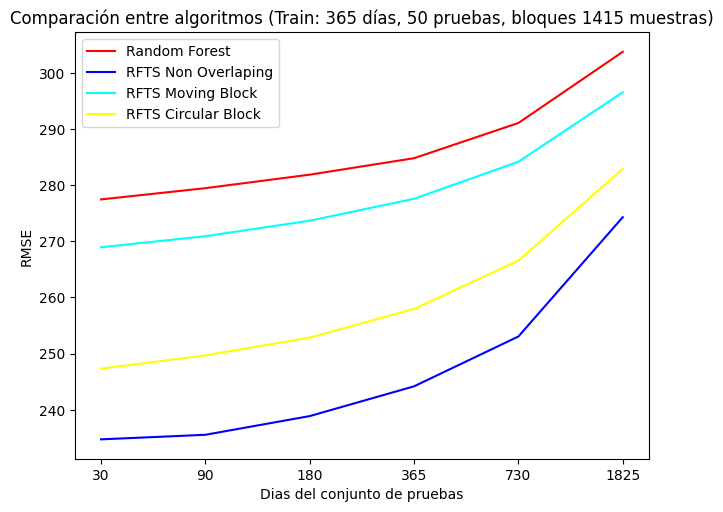

In [113]:
showGraphLinesForOneBlockSize(FrRMSE, NoRMSE[1415], BmRMSE[1415], CbRMSE[1415], "Train: 365 días, 50 pruebas, bloques 1415 muestras")

In [119]:
def runTrainTimeTest(trainDays, blockSize):
    bs = [blockSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults(trainDays + max(testRanges), trainDays, bs)
    graphDescr = f"Train: {trainDays} días, 50 pruebas, bloques {blockSize} muestras"
    showGraphLinesForOneBlockSize(FrRMSE, NoRMSE[blockSize], BmRMSE[blockSize], CbRMSE[blockSize],graphDescr )

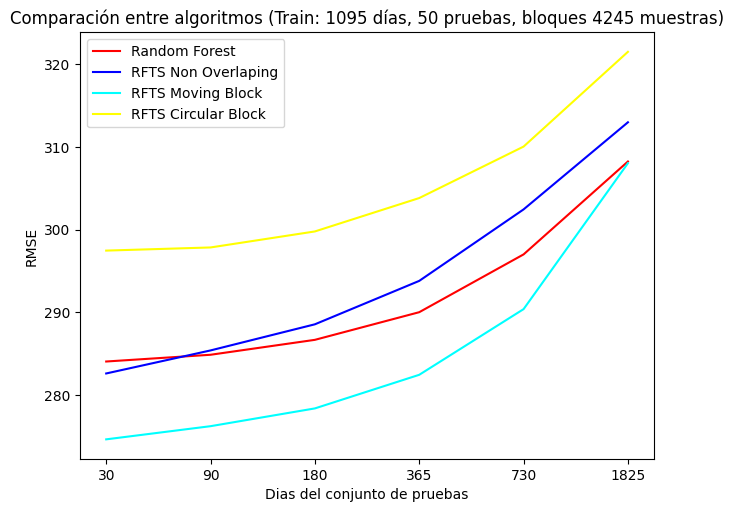

In [120]:
runTrainTimeTest(365 * 3, 1415 * 3)

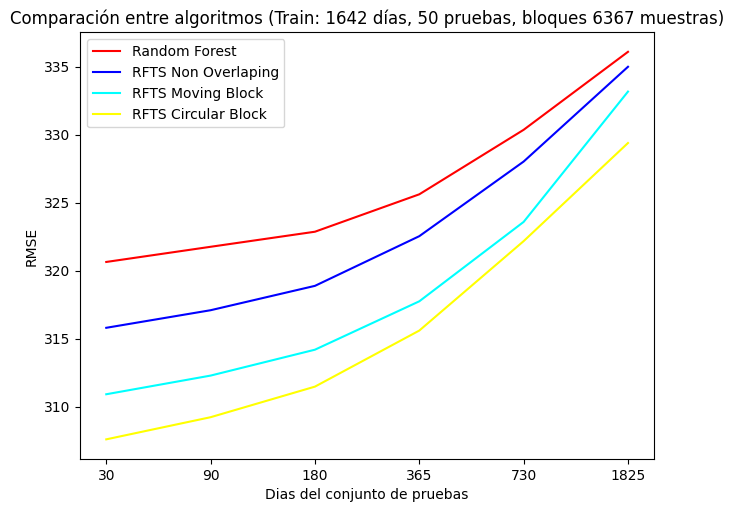

In [121]:
runTrainTimeTest(int(365 * 4.5), int(1415 * 4.5))

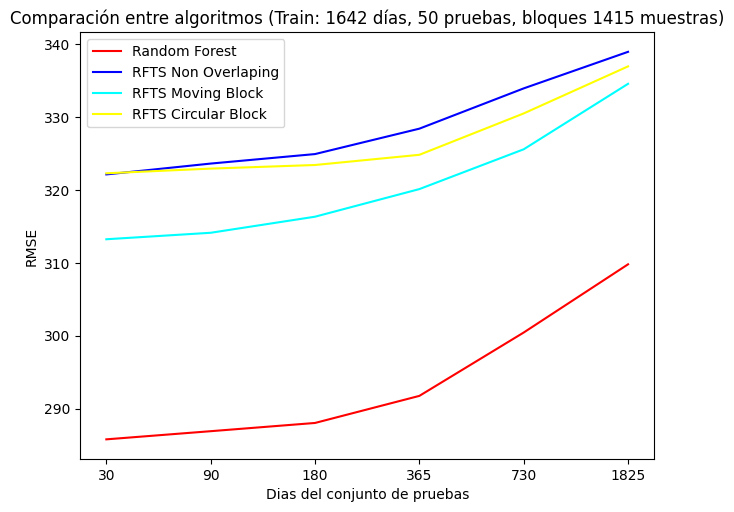

In [122]:
runTrainTimeTest(int(365 * 4.5), 1415)

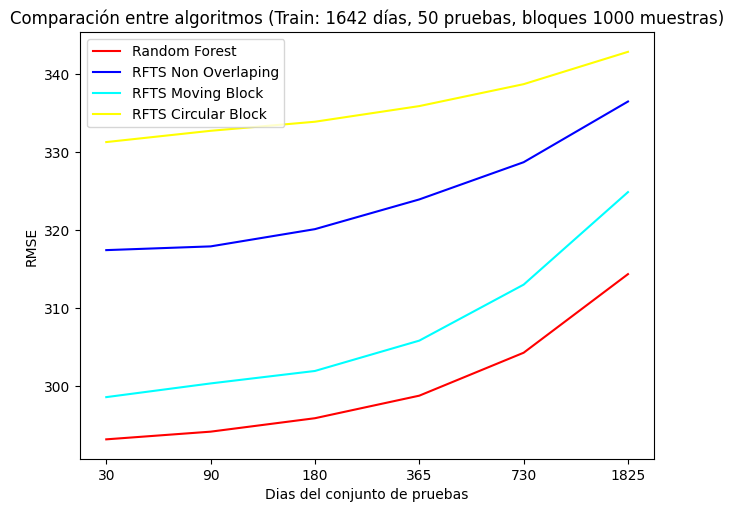

In [123]:
runTrainTimeTest(int(365 * 4.5), 1000)

In [174]:
def runTestAndCompareOneSigleBlockSize2(TrainDays, bSize):
    bs = [bSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults2(TrainDays + max(testRanges), TrainDays, bs)
    graphDescr = f"Train: {TrainDays} días, 50 pruebas, bloques {bSize} muestras"
    showGraphLinesForOneBlockSize(FrRMSE, NoRMSE[bSize], BmRMSE[bSize], CbRMSE[bSize],graphDescr)

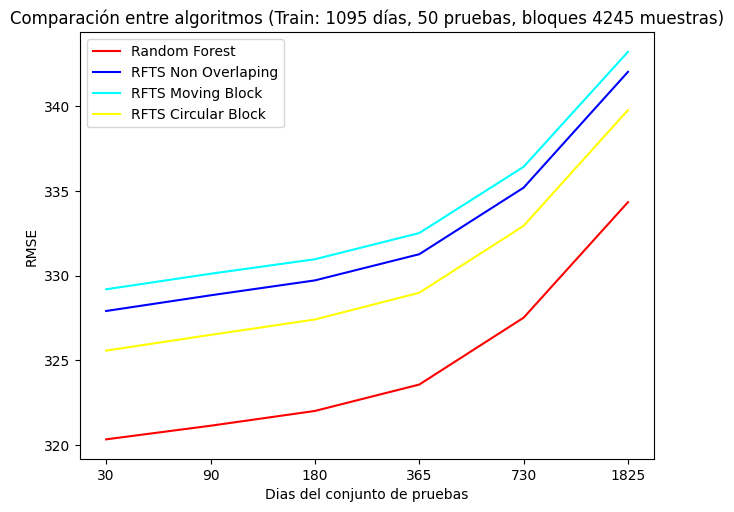

In [175]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), int(1415 * 3))

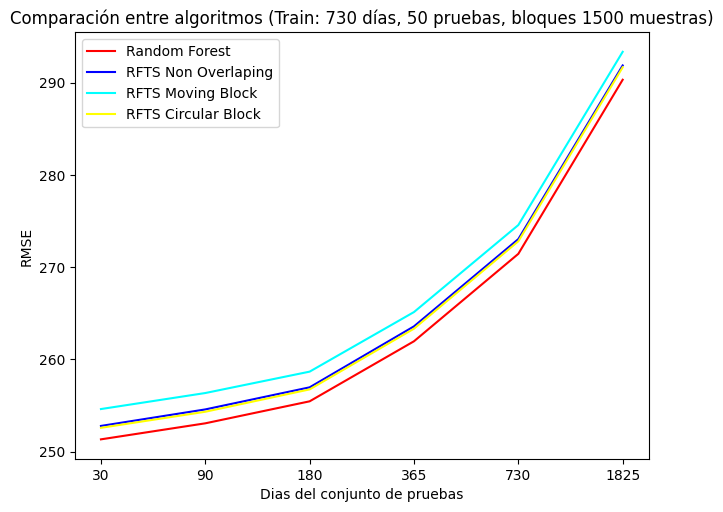

In [176]:
runTestAndCompareOneSigleBlockSize2(365 * 2, 1500)

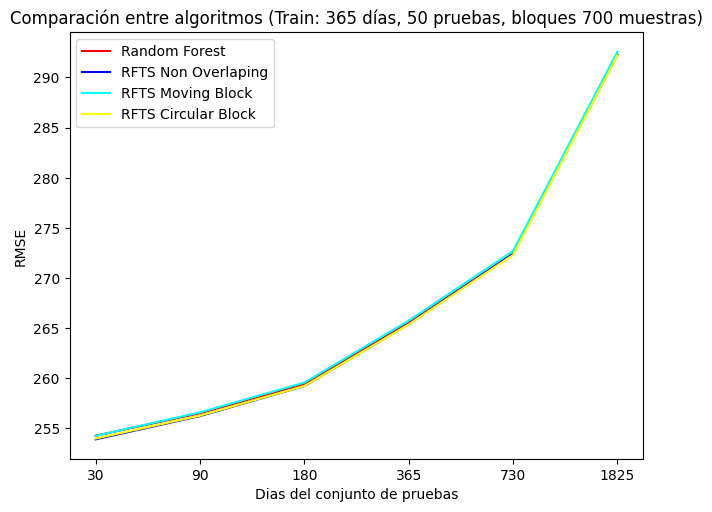

In [177]:
runTestAndCompareOneSigleBlockSize2(365, 700)

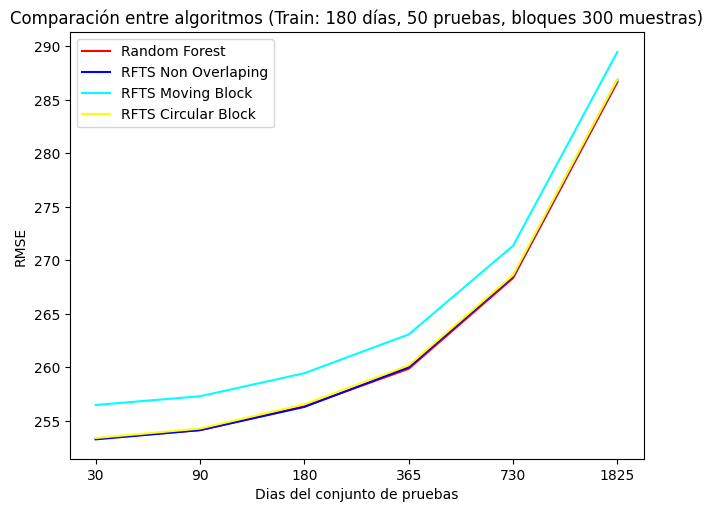

In [178]:
runTestAndCompareOneSigleBlockSize2(180, 300)

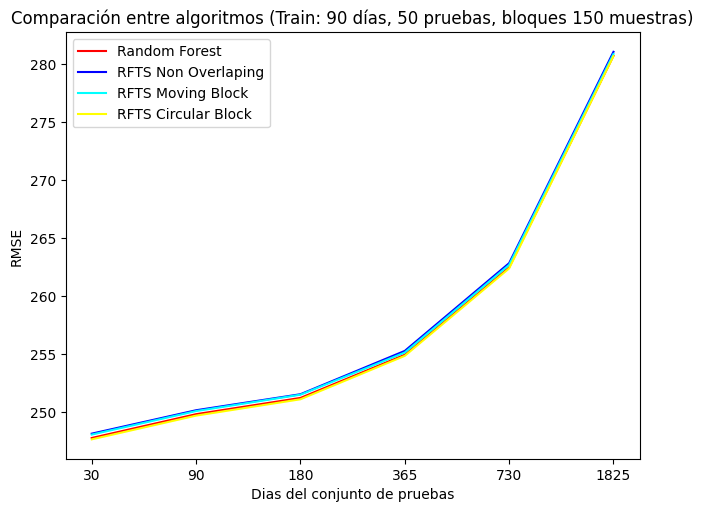

In [179]:
runTestAndCompareOneSigleBlockSize2(90, 150)

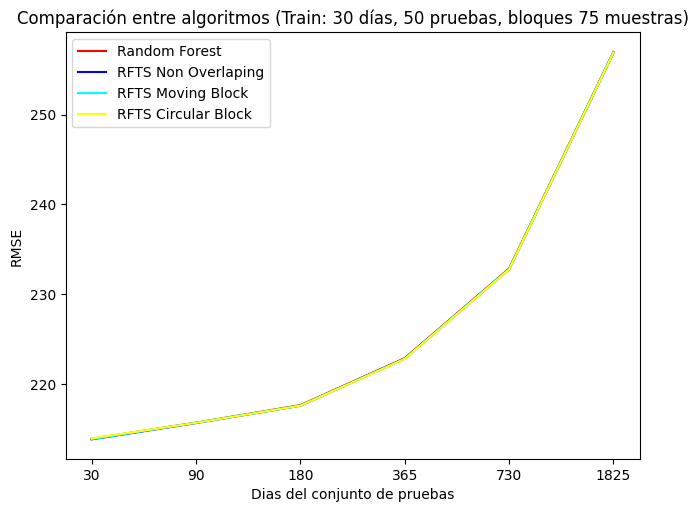

In [180]:
runTestAndCompareOneSigleBlockSize2(30, 75)

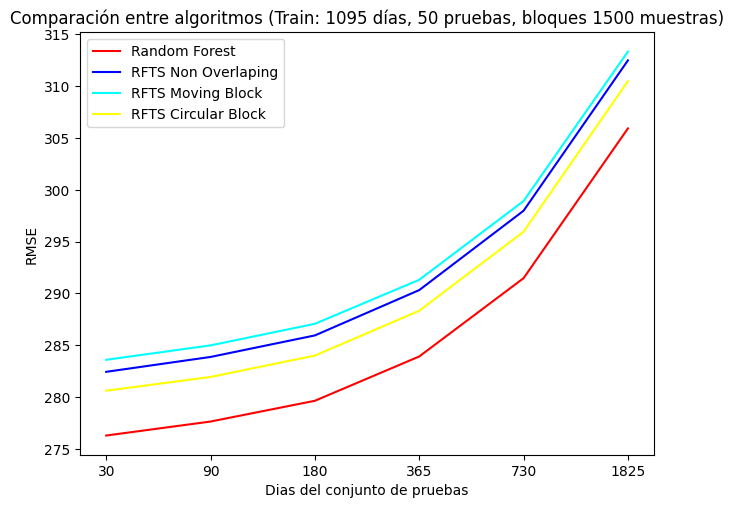

In [182]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), 1500)

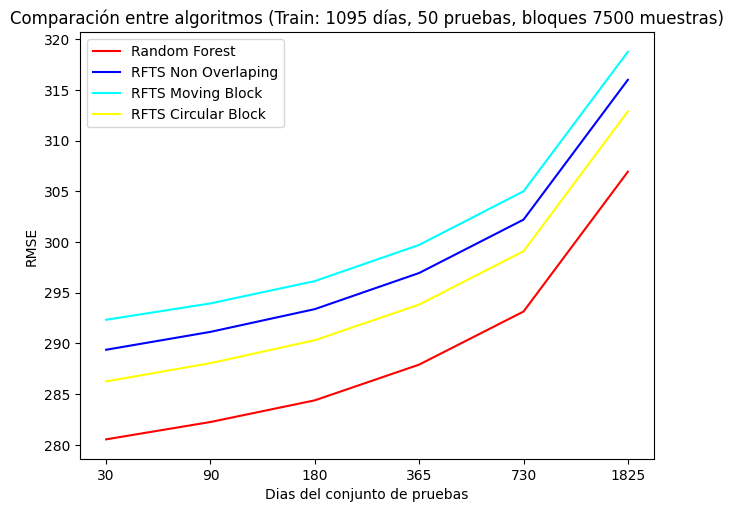

In [183]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), (1500 * 5))